In [69]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd


In [70]:

# Defining Malfliet-Tjon potential

def potential_V(r):
    
    # Realistik nukleon-nukleon potential of Malfliet-Tjon type.
    # Ref: R. A. Malfliet and J.A. Tjon
    # Nuclear Physics A127 (1969) 161-168
    
    # input: Radius r in 10^-15 m or 1 fm 
    # Output: Potential V in MeV
    
    
    l_1 = -586.04
    l_2 = 1458.19
    l_3 = -872.15
    
    mu_1 = 1.55
    mu_2 = 3.11
    mu_3 = 6.00
    
    V_1 = l_1*np.exp(-mu_1*r)
    V_2 = l_2*np.exp(-mu_2*r)
    V_3 = l_3*np.exp(-mu_3*r)
    
    V = (V_1+V_2+V_3)/r
    
    return V



In [76]:

# Populating Vr vector
def populate_Vr(Vr):
    
    for i in range(Vr.size):
    
        Vr[i] = potential_V(r[i])

    return Vr


In [98]:
def populate_Fvec(Fvec, Vr, E):
    
    # Mass of protron in MeV/c^2
    mass_protron = 938.272
    # Mass of neutron in MeV/c^2
    mass_neutron = 939.565
    # Reduced mass of the deutron
    my = (mass_protron*mass_neutron) / (mass_protron+mass_neutron)
    # hbar*c = 197.327 MeV*fm
    hbar = 197.327
    # The c cancels out from the MeV/c^2 unit of my
    K = 2 * my / hbar**2
    
    
    for i in range(Fvec.size):
    
        Fvec[i] = K*(Vr[i]-E)
    
    return Fvec
    

In [127]:

def numerov(u, Fvec, u_0, u_1, index, steplength, revese=False):
    
    #TODO: Python magic? Revers the u vector, calculate and revers back? 
    
    if revese:
        u = u[::-1]
    
    # Init outward integrated wave function
    u[0] = u_0
    u[1] = u_1
    h = steplength
    # Numverov outward
    for i in range(1,index):
        
        u_0 = u[i]
        u_neg_1 = u[i-1]
        
        F_1 = Fvec[i+1]
        F_0 = Fvec[i]
        F_neg_1 = Fvec[i-1]
        
        
        
        #print('Debugger')
        #print(f'u_0: {u_0}')
        #print(f'u_neg_1: {u_neg_1}')
        #print(f'F_1: {F_1}')
        #print(f'F_0: {F_0}')
        #print(f'F_neg_1: {F_neg_1}')
        
        outward_numerator = u_0*(2 + (5/6)*(h**2)*F_0) - u_neg_1*(1 - (1/12)*(h**2)*F_neg_1)
        outward_denominator = (1 - (1/12)*(h**2)*F_1)
        next_step = outward_numerator/outward_denominator
        u[i+1] = next_step
        
        #print(f'outward_numerator: {outward_numerator}')
        #print(f'outward_denominator: {outward_denominator}')
        #print(f'next_step: {next_step}')

    if revese:
        return u[::-1]

    else:
        return u


In [ ]:
# Declaring constants

# Grid in fm
rmax = 10.0
# Number of steps
N = 10000
# Step lengt
h = rmax / N

print(f'Steplengt: {h}')

# Init grid and potential V(r) for every r
# OBS: Never use 0
r = np.linspace(10.**-16, rmax, num=(N))
Vr = populate_Vr(np.zeros(N))
u = np.zeros(N)


In [49]:

# Set important parameters
# Guessing whatever was meintioned in the exercise
Emin = min(Vr)
Emax = 0.0
E = 0.5 * (Emin+Emax)
max_iter = 10000# TODO:
continuity_tolerance = 0.000001# TODO:


In [133]:

# Itterate over the energi E

for iter in range(max_iter):
    
    # Init Fvec(r) 
    # TODO: Write down equation
    # This vector is dependent on E
    Fvec = populate_Fvec(np.zeros(N), Vr, E)
        
    # Choose matching point (equvivalent grid index)
    # In exercise suggested to start at 1fm
    rmp_index = 1000
   
        
    print(f'Match r={r[rmp_index]}')
    
    # Init outward integrated wave function
    u_outer = numerov(np.zeros(N), Fvec, 0, h**1, rmp_index, h)
    u_out_mp = u[rmp_index]


    # Init inward integrated wave function
    u_inner = numerov(np.zeros(N), Fvec, 0, h**1, (N - rmp_index - 2), h, revese=True)
    u_in_mp = u[rmp_index+1]

    # Scaling factor between ingoing and outgoing wave function
    scalefactor = u_out_mp/u_in_mp
    
    # Match the height and create the full vector u
    u = u_outer + scalefactor * u_inner
    
    
    # Calculate the discontinuity of the derivitiv of mp
    # TODO: Figure out if i need the index here of the value of r?
    matching_numerator = (u[rmp_index]-h)+(u[rmp_index]+h) - u[rmp_index]*(2 + (h**2)*Fvec[rmp_index])
    matching_denominator = h
    matching = matching_numerator / matching_denominator
    
    if matching < continuity_tolerance:
        # Break the loop 
        break
    
    if u(rmp_index)*matching > 0:
        
        Emax = E
        
    if u(rmp_index)*matching < 0:
        
        Emin = E
    
    E = 0.5 (Emax+Emin)
    

Match r=1.000100010001


NameError: name 'continuity_tolerance' is not defined

In [ ]:

# After the code works:
# 1. Normalize the function so that the integral = 1
# 2. Calculate the observed radius in fm
# 3. Plot the wave function u(r)
# 4. Analyse the results 


In [33]:
rmp_index = 0
for i in range(r.size):
    if r[i] == 10.**-15:
        rmp_index = i

Steplengt: 0.001
[ 2.27373675e+03  1.59696378e+03  1.58768512e+03 ... -1.09092761e-05
 -1.08912886e-05 -1.08733310e-05]


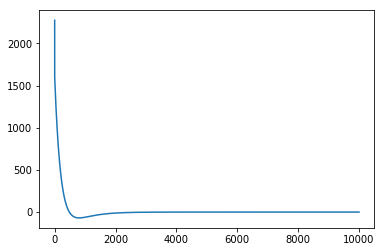

In [78]:

# Declaring constants

# Grid in fm
rmax = 10.0
# Number of steps
N = 10000
# Step lengt
h = rmax / N

print(f'Steplengt: {h}')

# Init grid and potential V(r) for every r
# OBS: Never use 0
r = np.linspace(10.**-16, rmax, num=(N))

u = np.zeros(N)
Vr = populate_Vr(np.zeros(N))

print(Vr)

plt.plot(Vr)

# Vector Vr is tested and looks good. populate_Vr working as expected. 


[55.66542144 39.34626624 39.12252816 ...  0.83837536  0.83837536
  0.83837536]


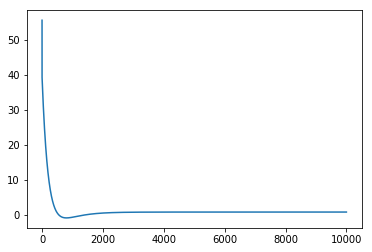

In [99]:


Emin = min(Vr)
Emax = 0.0
E = 0.5 * (Emin+Emax)
max_iter = 1# TODO:
continuity_epsilon = 1# TODO:

rmp_index = 1000

Fvec = populate_Fvec(np.zeros(N), Vr, E)

print(Fvec)

plt.plot(Fvec)

# Vector Fvec new tested and correct. 


[0.         0.         0.         ... 0.00200004 0.001      0.        ]
[0.         0.001      0.00200004 ... 0.         0.         0.        ]


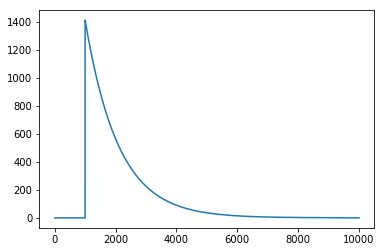

In [130]:

rmp_index = 1000

u_outer = numerov(np.zeros(N), Fvec, 0, h**1, rmp_index, h)
#plt.plot(u_outer)

u_inner = numerov(np.zeros(N), Fvec, 0, h**1, (N - rmp_index - 2), h, revese=True)
plt.plot(u_inner)


print(u_inner)
print(u_outer)



[0.         0.001      0.00200004 ... 0.00200004 0.001      0.        ]


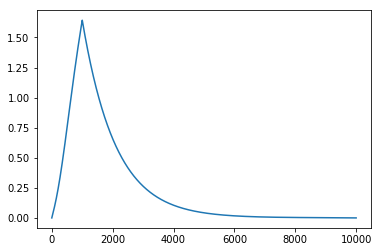

In [131]:
u_in_mp = u_inner[rmp_index+1]
u_out_mp = u_outer[rmp_index]
    
# Scaling factor between ingoing and outgoing wave function
scalefactor = u_out_mp/u_in_mp

plt.plot((scalefactor*u_inner+u_outer))


print(u_inner+u_outer)

# numerov are now tested

In [132]:

rmp_index = 1000

# Init outward integrated wave function
u_outer = numerov(np.zeros(N), Fvec, 0, h**1, rmp_index, h)
u_out_mp = u[rmp_index]


# Init inward integrated wave function
u_inner = numerov(np.zeros(N), Fvec, 0, h**1, (N - rmp_index - 2), h, revese=True)
u_in_mp = u[rmp_index+1]

# Scaling factor between ingoing and outgoing wave function
scalefactor = u_out_mp/u_in_mp
    
# Match the height and create the full vector u
u = u_outer + scalefactor * u_inner


# Calculate the discontinuity of the derivitiv of mp
# TODO: Figure out if i need the index here of the value of r?
matching_numerator = (u[rmp_index]-h)+(u[rmp_index]+h) - u[rmp_index]*(2 + (h**2)*Fvec[rmp_index])
matching_denominator = h
matching = matching_numerator / matching_denominator

print(matching)


0.0010591348464927819


In [135]:
# Set important parameters
# Guessing whatever was meintioned in the exercise
Emin = min(Vr)
Emax = 0.0
E = 0.5 * (Emin+Emax)
max_iter = 10000# TODO:
continuity_tolerance = 0.000001# TODO:

Match r=0.5000500050005001
Within tolerance!


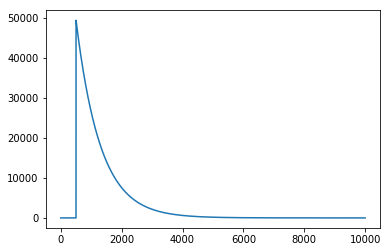

In [146]:

# Itterate over the energi E

for iter in range(max_iter):
    
    # Init Fvec(r) 
    # TODO: Write down equation
    # This vector is dependent on E
    Fvec = populate_Fvec(np.zeros(N), Vr, E)
        
    # Choose matching point (equvivalent grid index)
    # In exercise suggested to start at 1fm
    rmp_index = 500
   
        
    print(f'Match r={r[rmp_index]}')
    
    # Init outward integrated wave function
    u_outer = numerov(np.zeros(N), Fvec, 0, h**1, rmp_index, h)
    u_out_mp = u[rmp_index]


    # Init inward integrated wave function
    u_inner = numerov(np.zeros(N), Fvec, 0, h**1, (N - rmp_index - 2), h, revese=True)
    u_in_mp = u[rmp_index+1]

    # Scaling factor between ingoing and outgoing wave function
    scale_factor = u_out_mp / u_in_mp
    
    # Match the height and create the full vector u
    u = u_outer + scale_factor * u_inner
    
    
    # Calculate the discontinuity of the derivitiv of mp
    # TODO: Figure out if i need the index here of the value of r?
    matching_numerator = (u[rmp_index]-h)+(u[rmp_index]+h) - u[rmp_index]*(2 + (h**2)*Fvec[rmp_index])
    matching_denominator = h
    matching = matching_numerator / matching_denominator
    
    if matching < continuity_tolerance:
        # Break the loop
        print('Within tolerance!')
        break
    
    if u[rmp_index]*matching > 0:
        
        Emax = E
        
    if u[rmp_index]*matching < 0:
        
        Emin = E
    
    E = 0.5 * (Emax+Emin)
    
plt.plot(u)